In [ ]:
import torch
from torch import nn
from torchvision import transforms

from _models import (
    CoordinateCNN,
    CoordinateDataset,
    create_data_loaders,
    evaluate_model,
    plot_training_history,
    train_and_validate,
)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformations (without normalization for images)
transform: transforms.Compose = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

# Create dataset and dataloader
dataset: CoordinateDataset = CoordinateDataset("./train", transform)

Label file train/plants/labels/000000175.txt does not exist.
Label file train/plants/labels/000000174.txt does not exist.
Error reading train/plants/labels/000000160.txt: could not convert string to float: ''
Label file train/plants/labels/000000148.txt does not exist.
Label file train/plants/labels/000000147.txt does not exist.
Error reading train/plants/labels/000000135.txt: could not convert string to float: ''
Error reading train/plants/labels/000000112.txt: could not convert string to float: ''
Error reading train/plants/labels/000000056.txt: could not convert string to float: ''
Error reading train/furniture/labels/0000000391.txt: could not convert string to float: ''
Error reading train/furniture/labels/0000000381.txt: could not convert string to float: ''
Error reading train/furniture/labels/00000003311.txt: could not convert string to float: ''
Label file train/coolLighting/labels/0000000351.txt does not exist.
Error reading train/cameraDistance/labels/000000024.txt: could not

In [2]:
# Create data loaders with train-test split
train_loader, val_loader, test_loader = create_data_loaders(dataset)

# Initialize model
model = CoordinateCNN().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train and validate the model
history = train_and_validate(
    device,
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=200,
    patience=20,
)

Dataset split: Train=859, Validation=95, Test=238


Epoch 1/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s, loss=0.0337]


Epoch 1/200 - Train Loss: 61.941437, Val Loss: 0.036006
Validation loss decreased (inf --> 0.036006).  Saving model ...


Epoch 2/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.0171]


Epoch 2/200 - Train Loss: 0.048624, Val Loss: 0.019039
Validation loss decreased (0.036006 --> 0.019039).  Saving model ...


Epoch 3/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.0145]


Epoch 3/200 - Train Loss: 0.028548, Val Loss: 0.015475
Validation loss decreased (0.019039 --> 0.015475).  Saving model ...


Epoch 4/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.0145]


Epoch 4/200 - Train Loss: 0.023006, Val Loss: 0.014198
Validation loss decreased (0.015475 --> 0.014198).  Saving model ...


Epoch 5/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.0163]


Epoch 5/200 - Train Loss: 0.020055, Val Loss: 0.015923
EarlyStopping counter: 1 out of 20


Epoch 6/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.0133] 


Epoch 6/200 - Train Loss: 0.017249, Val Loss: 0.012965
Validation loss decreased (0.014198 --> 0.012965).  Saving model ...


Epoch 7/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s, loss=0.014]  


Epoch 7/200 - Train Loss: 0.016182, Val Loss: 0.013334
EarlyStopping counter: 1 out of 20


Epoch 8/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.0135] 


Epoch 8/200 - Train Loss: 0.015179, Val Loss: 0.013016
EarlyStopping counter: 2 out of 20


Epoch 9/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.0111] 


Epoch 9/200 - Train Loss: 0.013540, Val Loss: 0.010447
Validation loss decreased (0.012965 --> 0.010447).  Saving model ...


Epoch 10/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.0115] 


Epoch 10/200 - Train Loss: 0.012308, Val Loss: 0.011354
EarlyStopping counter: 1 out of 20


Epoch 11/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.01]   


Epoch 11/200 - Train Loss: 0.011873, Val Loss: 0.009557
Validation loss decreased (0.010447 --> 0.009557).  Saving model ...


Epoch 12/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.0106]


Epoch 12/200 - Train Loss: 0.010899, Val Loss: 0.009643
EarlyStopping counter: 1 out of 20


Epoch 13/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s, loss=0.0106] 


Epoch 13/200 - Train Loss: 0.009681, Val Loss: 0.009382
Validation loss decreased (0.009557 --> 0.009382).  Saving model ...


Epoch 14/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00858]


Epoch 14/200 - Train Loss: 0.009525, Val Loss: 0.007821
Validation loss decreased (0.009382 --> 0.007821).  Saving model ...


Epoch 15/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00846]


Epoch 15/200 - Train Loss: 0.009347, Val Loss: 0.007936
EarlyStopping counter: 1 out of 20


Epoch 16/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00899]


Epoch 16/200 - Train Loss: 0.008332, Val Loss: 0.008110
EarlyStopping counter: 2 out of 20


Epoch 17/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00818]


Epoch 17/200 - Train Loss: 0.007757, Val Loss: 0.007329
Validation loss decreased (0.007821 --> 0.007329).  Saving model ...


Epoch 18/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00849]


Epoch 18/200 - Train Loss: 0.007228, Val Loss: 0.007919
EarlyStopping counter: 1 out of 20


Epoch 19/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s, loss=0.00808]


Epoch 19/200 - Train Loss: 0.006988, Val Loss: 0.007521
EarlyStopping counter: 2 out of 20


Epoch 20/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00748]


Epoch 20/200 - Train Loss: 0.006503, Val Loss: 0.006673
Validation loss decreased (0.007329 --> 0.006673).  Saving model ...


Epoch 21/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s, loss=0.00749]


Epoch 21/200 - Train Loss: 0.006476, Val Loss: 0.007215
EarlyStopping counter: 1 out of 20


Epoch 22/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00743]


Epoch 22/200 - Train Loss: 0.006588, Val Loss: 0.006669
Validation loss decreased (0.006673 --> 0.006669).  Saving model ...


Epoch 23/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00728]


Epoch 23/200 - Train Loss: 0.005890, Val Loss: 0.006686
EarlyStopping counter: 1 out of 20


Epoch 24/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00719]


Epoch 24/200 - Train Loss: 0.005621, Val Loss: 0.006963
EarlyStopping counter: 2 out of 20


Epoch 25/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.0067] 


Epoch 25/200 - Train Loss: 0.005042, Val Loss: 0.006129
Validation loss decreased (0.006669 --> 0.006129).  Saving model ...


Epoch 26/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00776]


Epoch 26/200 - Train Loss: 0.005231, Val Loss: 0.007163
EarlyStopping counter: 1 out of 20


Epoch 27/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00643]


Epoch 27/200 - Train Loss: 0.005147, Val Loss: 0.006190
EarlyStopping counter: 2 out of 20


Epoch 28/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00671]


Epoch 28/200 - Train Loss: 0.004759, Val Loss: 0.006353
EarlyStopping counter: 3 out of 20


Epoch 29/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00668]


Epoch 29/200 - Train Loss: 0.004775, Val Loss: 0.006073
Validation loss decreased (0.006129 --> 0.006073).  Saving model ...


Epoch 30/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00625]


Epoch 30/200 - Train Loss: 0.004571, Val Loss: 0.005968
Validation loss decreased (0.006073 --> 0.005968).  Saving model ...


Epoch 31/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00687]


Epoch 31/200 - Train Loss: 0.004580, Val Loss: 0.006346
EarlyStopping counter: 1 out of 20


Epoch 32/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00718]


Epoch 32/200 - Train Loss: 0.004293, Val Loss: 0.006456
EarlyStopping counter: 2 out of 20


Epoch 33/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00662]


Epoch 33/200 - Train Loss: 0.004130, Val Loss: 0.005846
Validation loss decreased (0.005968 --> 0.005846).  Saving model ...


Epoch 34/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s, loss=0.00679]


Epoch 34/200 - Train Loss: 0.003898, Val Loss: 0.006142
EarlyStopping counter: 1 out of 20


Epoch 35/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s, loss=0.00654]


Epoch 35/200 - Train Loss: 0.003737, Val Loss: 0.005938
EarlyStopping counter: 2 out of 20


Epoch 36/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00672]


Epoch 36/200 - Train Loss: 0.003945, Val Loss: 0.006018
EarlyStopping counter: 3 out of 20


Epoch 37/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00654]


Epoch 37/200 - Train Loss: 0.003516, Val Loss: 0.005807
Validation loss decreased (0.005846 --> 0.005807).  Saving model ...


Epoch 38/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00715]


Epoch 38/200 - Train Loss: 0.003480, Val Loss: 0.006445
EarlyStopping counter: 1 out of 20


Epoch 39/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00631]


Epoch 39/200 - Train Loss: 0.003397, Val Loss: 0.005895
EarlyStopping counter: 2 out of 20


Epoch 40/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=0.00619]


Epoch 40/200 - Train Loss: 0.003732, Val Loss: 0.005978
EarlyStopping counter: 3 out of 20


Epoch 41/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00614]


Epoch 41/200 - Train Loss: 0.003414, Val Loss: 0.005845
EarlyStopping counter: 4 out of 20


Epoch 42/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s, loss=0.00593]


Epoch 42/200 - Train Loss: 0.003312, Val Loss: 0.005599
Validation loss decreased (0.005807 --> 0.005599).  Saving model ...


Epoch 43/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s, loss=0.0067] 


Epoch 43/200 - Train Loss: 0.003035, Val Loss: 0.006065
EarlyStopping counter: 1 out of 20


Epoch 44/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s, loss=0.00682]


Epoch 44/200 - Train Loss: 0.003031, Val Loss: 0.005929
EarlyStopping counter: 2 out of 20


Epoch 45/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00674]


Epoch 45/200 - Train Loss: 0.003097, Val Loss: 0.005988
EarlyStopping counter: 3 out of 20


Epoch 46/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00672]


Epoch 46/200 - Train Loss: 0.003048, Val Loss: 0.006108
EarlyStopping counter: 4 out of 20


Epoch 47/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00685]


Epoch 47/200 - Train Loss: 0.002953, Val Loss: 0.006032
EarlyStopping counter: 5 out of 20


Epoch 48/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00541]


Epoch 48/200 - Train Loss: 0.003639, Val Loss: 0.005161
Validation loss decreased (0.005599 --> 0.005161).  Saving model ...


Epoch 49/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s, loss=0.00592]


Epoch 49/200 - Train Loss: 0.003418, Val Loss: 0.005531
EarlyStopping counter: 1 out of 20


Epoch 50/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.00634]


Epoch 50/200 - Train Loss: 0.002969, Val Loss: 0.005849
EarlyStopping counter: 2 out of 20


Epoch 51/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00524]


Epoch 51/200 - Train Loss: 0.002749, Val Loss: 0.005065
Validation loss decreased (0.005161 --> 0.005065).  Saving model ...


Epoch 52/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00612]


Epoch 52/200 - Train Loss: 0.002995, Val Loss: 0.005669
EarlyStopping counter: 1 out of 20


Epoch 53/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00604]


Epoch 53/200 - Train Loss: 0.002741, Val Loss: 0.005777
EarlyStopping counter: 2 out of 20


Epoch 54/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=0.00568]


Epoch 54/200 - Train Loss: 0.002707, Val Loss: 0.005261
EarlyStopping counter: 3 out of 20


Epoch 55/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00616]


Epoch 55/200 - Train Loss: 0.002644, Val Loss: 0.005558
EarlyStopping counter: 4 out of 20


Epoch 56/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00727]


Epoch 56/200 - Train Loss: 0.002756, Val Loss: 0.006427
EarlyStopping counter: 5 out of 20


Epoch 57/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00608]


Epoch 57/200 - Train Loss: 0.002841, Val Loss: 0.005636
EarlyStopping counter: 6 out of 20


Epoch 58/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00583]


Epoch 58/200 - Train Loss: 0.002469, Val Loss: 0.005501
EarlyStopping counter: 7 out of 20


Epoch 59/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s, loss=0.00614]


Epoch 59/200 - Train Loss: 0.002406, Val Loss: 0.005677
EarlyStopping counter: 8 out of 20


Epoch 60/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s, loss=0.00587]


Epoch 60/200 - Train Loss: 0.002405, Val Loss: 0.005383
EarlyStopping counter: 9 out of 20


Epoch 61/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00543]


Epoch 61/200 - Train Loss: 0.002404, Val Loss: 0.005147
EarlyStopping counter: 10 out of 20


Epoch 62/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=0.00583]


Epoch 62/200 - Train Loss: 0.002424, Val Loss: 0.005311
EarlyStopping counter: 11 out of 20


Epoch 63/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00523]


Epoch 63/200 - Train Loss: 0.002724, Val Loss: 0.005189
EarlyStopping counter: 12 out of 20


Epoch 64/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s, loss=0.00622]


Epoch 64/200 - Train Loss: 0.003020, Val Loss: 0.006704
EarlyStopping counter: 13 out of 20


Epoch 65/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.0063] 


Epoch 65/200 - Train Loss: 0.002784, Val Loss: 0.005571
EarlyStopping counter: 14 out of 20


Epoch 66/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00559]


Epoch 66/200 - Train Loss: 0.002528, Val Loss: 0.005121
EarlyStopping counter: 15 out of 20


Epoch 67/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00611]


Epoch 67/200 - Train Loss: 0.002548, Val Loss: 0.005420
EarlyStopping counter: 16 out of 20


Epoch 68/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00549]


Epoch 68/200 - Train Loss: 0.002352, Val Loss: 0.004993
Validation loss decreased (0.005065 --> 0.004993).  Saving model ...


Epoch 69/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00595]


Epoch 69/200 - Train Loss: 0.002337, Val Loss: 0.005474
EarlyStopping counter: 1 out of 20


Epoch 70/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00584]


Epoch 70/200 - Train Loss: 0.002322, Val Loss: 0.005384
EarlyStopping counter: 2 out of 20


Epoch 71/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00548]


Epoch 71/200 - Train Loss: 0.002287, Val Loss: 0.005185
EarlyStopping counter: 3 out of 20


Epoch 72/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00602]


Epoch 72/200 - Train Loss: 0.002455, Val Loss: 0.005539
EarlyStopping counter: 4 out of 20


Epoch 73/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s, loss=0.00584]


Epoch 73/200 - Train Loss: 0.002169, Val Loss: 0.005227
EarlyStopping counter: 5 out of 20


Epoch 74/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00565]


Epoch 74/200 - Train Loss: 0.002138, Val Loss: 0.005380
EarlyStopping counter: 6 out of 20


Epoch 75/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00536]


Epoch 75/200 - Train Loss: 0.002468, Val Loss: 0.005186
EarlyStopping counter: 7 out of 20


Epoch 76/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00599]


Epoch 76/200 - Train Loss: 0.002308, Val Loss: 0.005377
EarlyStopping counter: 8 out of 20


Epoch 77/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00559]


Epoch 77/200 - Train Loss: 0.002011, Val Loss: 0.005147
EarlyStopping counter: 9 out of 20


Epoch 78/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00558]


Epoch 78/200 - Train Loss: 0.002048, Val Loss: 0.005128
EarlyStopping counter: 10 out of 20


Epoch 79/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00515]


Epoch 79/200 - Train Loss: 0.002134, Val Loss: 0.005020
EarlyStopping counter: 11 out of 20


Epoch 80/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s, loss=0.00575]


Epoch 80/200 - Train Loss: 0.002022, Val Loss: 0.005084
EarlyStopping counter: 12 out of 20


Epoch 81/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00573]


Epoch 81/200 - Train Loss: 0.002045, Val Loss: 0.005191
EarlyStopping counter: 13 out of 20


Epoch 82/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00559]


Epoch 82/200 - Train Loss: 0.002043, Val Loss: 0.005173
EarlyStopping counter: 14 out of 20


Epoch 83/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00559]


Epoch 83/200 - Train Loss: 0.001962, Val Loss: 0.004975
Validation loss decreased (0.004993 --> 0.004975).  Saving model ...


Epoch 84/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s, loss=0.00517]


Epoch 84/200 - Train Loss: 0.002061, Val Loss: 0.004929
Validation loss decreased (0.004975 --> 0.004929).  Saving model ...


Epoch 85/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00533]


Epoch 85/200 - Train Loss: 0.002329, Val Loss: 0.004767
Validation loss decreased (0.004929 --> 0.004767).  Saving model ...


Epoch 86/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00589]


Epoch 86/200 - Train Loss: 0.002078, Val Loss: 0.005128
EarlyStopping counter: 1 out of 20


Epoch 87/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00577]


Epoch 87/200 - Train Loss: 0.001854, Val Loss: 0.005021
EarlyStopping counter: 2 out of 20


Epoch 88/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00563]


Epoch 88/200 - Train Loss: 0.001896, Val Loss: 0.005010
EarlyStopping counter: 3 out of 20


Epoch 89/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00616]


Epoch 89/200 - Train Loss: 0.001883, Val Loss: 0.005397
EarlyStopping counter: 4 out of 20


Epoch 90/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00583]


Epoch 90/200 - Train Loss: 0.001911, Val Loss: 0.005174
EarlyStopping counter: 5 out of 20


Epoch 91/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00557]


Epoch 91/200 - Train Loss: 0.001791, Val Loss: 0.004956
EarlyStopping counter: 6 out of 20


Epoch 92/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.0053] 


Epoch 92/200 - Train Loss: 0.001931, Val Loss: 0.004799
EarlyStopping counter: 7 out of 20


Epoch 93/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00535]


Epoch 93/200 - Train Loss: 0.001738, Val Loss: 0.004890
EarlyStopping counter: 8 out of 20


Epoch 94/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00525]


Epoch 94/200 - Train Loss: 0.001886, Val Loss: 0.004849
EarlyStopping counter: 9 out of 20


Epoch 95/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00507]


Epoch 95/200 - Train Loss: 0.002102, Val Loss: 0.004891
EarlyStopping counter: 10 out of 20


Epoch 96/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00511]


Epoch 96/200 - Train Loss: 0.001846, Val Loss: 0.004858
EarlyStopping counter: 11 out of 20


Epoch 97/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00632]


Epoch 97/200 - Train Loss: 0.002286, Val Loss: 0.005764
EarlyStopping counter: 12 out of 20


Epoch 98/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00514]


Epoch 98/200 - Train Loss: 0.002116, Val Loss: 0.004663
Validation loss decreased (0.004767 --> 0.004663).  Saving model ...


Epoch 99/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.0063]


Epoch 99/200 - Train Loss: 0.001966, Val Loss: 0.005624
EarlyStopping counter: 1 out of 20


Epoch 100/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s, loss=0.005]  


Epoch 100/200 - Train Loss: 0.002138, Val Loss: 0.004769
EarlyStopping counter: 2 out of 20


Epoch 101/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00589]


Epoch 101/200 - Train Loss: 0.002620, Val Loss: 0.005043
EarlyStopping counter: 3 out of 20


Epoch 102/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00584]


Epoch 102/200 - Train Loss: 0.001980, Val Loss: 0.005119
EarlyStopping counter: 4 out of 20


Epoch 103/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00533]


Epoch 103/200 - Train Loss: 0.001843, Val Loss: 0.005001
EarlyStopping counter: 5 out of 20


Epoch 104/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00529]


Epoch 104/200 - Train Loss: 0.001701, Val Loss: 0.004749
EarlyStopping counter: 6 out of 20


Epoch 105/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00538]


Epoch 105/200 - Train Loss: 0.001686, Val Loss: 0.004879
EarlyStopping counter: 7 out of 20


Epoch 106/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00545]


Epoch 106/200 - Train Loss: 0.001653, Val Loss: 0.004945
EarlyStopping counter: 8 out of 20


Epoch 107/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00525]


Epoch 107/200 - Train Loss: 0.001725, Val Loss: 0.004725
EarlyStopping counter: 9 out of 20


Epoch 108/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00537]


Epoch 108/200 - Train Loss: 0.001702, Val Loss: 0.004841
EarlyStopping counter: 10 out of 20


Epoch 109/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s, loss=0.00546]


Epoch 109/200 - Train Loss: 0.001689, Val Loss: 0.004911
EarlyStopping counter: 11 out of 20


Epoch 110/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00545]


Epoch 110/200 - Train Loss: 0.001705, Val Loss: 0.004715
EarlyStopping counter: 12 out of 20


Epoch 111/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00512]


Epoch 111/200 - Train Loss: 0.001839, Val Loss: 0.004664
EarlyStopping counter: 13 out of 20


Epoch 112/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00589]


Epoch 112/200 - Train Loss: 0.001707, Val Loss: 0.005084
EarlyStopping counter: 14 out of 20


Epoch 113/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00563]


Epoch 113/200 - Train Loss: 0.001578, Val Loss: 0.004966
EarlyStopping counter: 15 out of 20


Epoch 114/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00522]


Epoch 114/200 - Train Loss: 0.001672, Val Loss: 0.004698
EarlyStopping counter: 16 out of 20


Epoch 115/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00507]


Epoch 115/200 - Train Loss: 0.001622, Val Loss: 0.004627
Validation loss decreased (0.004663 --> 0.004627).  Saving model ...


Epoch 116/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00567]


Epoch 116/200 - Train Loss: 0.001587, Val Loss: 0.005123
EarlyStopping counter: 1 out of 20


Epoch 117/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s, loss=0.00539]


Epoch 117/200 - Train Loss: 0.001596, Val Loss: 0.004766
EarlyStopping counter: 2 out of 20


Epoch 118/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00532]


Epoch 118/200 - Train Loss: 0.001628, Val Loss: 0.004928
EarlyStopping counter: 3 out of 20


Epoch 119/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00535]


Epoch 119/200 - Train Loss: 0.001663, Val Loss: 0.004700
EarlyStopping counter: 4 out of 20


Epoch 120/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s, loss=0.00527]


Epoch 120/200 - Train Loss: 0.001626, Val Loss: 0.004811
EarlyStopping counter: 5 out of 20


Epoch 121/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00562]


Epoch 121/200 - Train Loss: 0.001513, Val Loss: 0.004959
EarlyStopping counter: 6 out of 20


Epoch 122/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s, loss=0.0053] 


Epoch 122/200 - Train Loss: 0.001636, Val Loss: 0.004712
EarlyStopping counter: 7 out of 20


Epoch 123/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00517]


Epoch 123/200 - Train Loss: 0.001579, Val Loss: 0.004619
Validation loss decreased (0.004627 --> 0.004619).  Saving model ...


Epoch 124/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s, loss=0.00528]


Epoch 124/200 - Train Loss: 0.001432, Val Loss: 0.004830
EarlyStopping counter: 1 out of 20


Epoch 125/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00506]


Epoch 125/200 - Train Loss: 0.001471, Val Loss: 0.004665
EarlyStopping counter: 2 out of 20


Epoch 126/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00559]


Epoch 126/200 - Train Loss: 0.001527, Val Loss: 0.004894
EarlyStopping counter: 3 out of 20


Epoch 127/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.00538]


Epoch 127/200 - Train Loss: 0.001511, Val Loss: 0.004932
EarlyStopping counter: 4 out of 20


Epoch 128/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00484]


Epoch 128/200 - Train Loss: 0.001626, Val Loss: 0.004562
Validation loss decreased (0.004619 --> 0.004562).  Saving model ...


Epoch 129/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00585]


Epoch 129/200 - Train Loss: 0.001680, Val Loss: 0.005322
EarlyStopping counter: 1 out of 20


Epoch 130/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00532]


Epoch 130/200 - Train Loss: 0.001619, Val Loss: 0.004737
EarlyStopping counter: 2 out of 20


Epoch 131/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00489]


Epoch 131/200 - Train Loss: 0.001632, Val Loss: 0.004475
Validation loss decreased (0.004562 --> 0.004475).  Saving model ...


Epoch 132/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00615]


Epoch 132/200 - Train Loss: 0.001638, Val Loss: 0.005401
EarlyStopping counter: 1 out of 20


Epoch 133/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00497]


Epoch 133/200 - Train Loss: 0.001679, Val Loss: 0.004566
EarlyStopping counter: 2 out of 20


Epoch 134/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00475]


Epoch 134/200 - Train Loss: 0.001585, Val Loss: 0.004366
Validation loss decreased (0.004475 --> 0.004366).  Saving model ...


Epoch 135/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.0052] 


Epoch 135/200 - Train Loss: 0.001902, Val Loss: 0.004426
EarlyStopping counter: 1 out of 20


Epoch 136/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00559]


Epoch 136/200 - Train Loss: 0.001601, Val Loss: 0.004779
EarlyStopping counter: 2 out of 20


Epoch 137/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.00523]


Epoch 137/200 - Train Loss: 0.001594, Val Loss: 0.004490
EarlyStopping counter: 3 out of 20


Epoch 138/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00504]


Epoch 138/200 - Train Loss: 0.001534, Val Loss: 0.004420
EarlyStopping counter: 4 out of 20


Epoch 139/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00508]


Epoch 139/200 - Train Loss: 0.001408, Val Loss: 0.004516
EarlyStopping counter: 5 out of 20


Epoch 140/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00528]


Epoch 140/200 - Train Loss: 0.001517, Val Loss: 0.004764
EarlyStopping counter: 6 out of 20


Epoch 141/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00531]


Epoch 141/200 - Train Loss: 0.001511, Val Loss: 0.004820
EarlyStopping counter: 7 out of 20


Epoch 142/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00473]


Epoch 142/200 - Train Loss: 0.001582, Val Loss: 0.004352
Validation loss decreased (0.004366 --> 0.004352).  Saving model ...


Epoch 143/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s, loss=0.00505]


Epoch 143/200 - Train Loss: 0.001503, Val Loss: 0.004489
EarlyStopping counter: 1 out of 20


Epoch 144/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s, loss=0.00477]


Epoch 144/200 - Train Loss: 0.001395, Val Loss: 0.004301
Validation loss decreased (0.004352 --> 0.004301).  Saving model ...


Epoch 145/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00532]


Epoch 145/200 - Train Loss: 0.001412, Val Loss: 0.004675
EarlyStopping counter: 1 out of 20


Epoch 146/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00467]


Epoch 146/200 - Train Loss: 0.001437, Val Loss: 0.004191
Validation loss decreased (0.004301 --> 0.004191).  Saving model ...


Epoch 147/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00501]


Epoch 147/200 - Train Loss: 0.001525, Val Loss: 0.004590
EarlyStopping counter: 1 out of 20


Epoch 148/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.005]  


Epoch 148/200 - Train Loss: 0.001406, Val Loss: 0.004351
EarlyStopping counter: 2 out of 20


Epoch 149/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00456]


Epoch 149/200 - Train Loss: 0.001326, Val Loss: 0.004076
Validation loss decreased (0.004191 --> 0.004076).  Saving model ...


Epoch 150/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00538]


Epoch 150/200 - Train Loss: 0.001426, Val Loss: 0.004634
EarlyStopping counter: 1 out of 20


Epoch 151/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s, loss=0.0047] 


Epoch 151/200 - Train Loss: 0.001297, Val Loss: 0.004289
EarlyStopping counter: 2 out of 20


Epoch 152/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00507]


Epoch 152/200 - Train Loss: 0.001323, Val Loss: 0.004535
EarlyStopping counter: 3 out of 20


Epoch 153/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00516]


Epoch 153/200 - Train Loss: 0.001395, Val Loss: 0.004488
EarlyStopping counter: 4 out of 20


Epoch 154/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00528]


Epoch 154/200 - Train Loss: 0.001303, Val Loss: 0.004733
EarlyStopping counter: 5 out of 20


Epoch 155/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.0052] 


Epoch 155/200 - Train Loss: 0.001376, Val Loss: 0.004665
EarlyStopping counter: 6 out of 20


Epoch 156/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=0.00594]


Epoch 156/200 - Train Loss: 0.001445, Val Loss: 0.005051
EarlyStopping counter: 7 out of 20


Epoch 157/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00479]


Epoch 157/200 - Train Loss: 0.001349, Val Loss: 0.004378
EarlyStopping counter: 8 out of 20


Epoch 158/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00528]


Epoch 158/200 - Train Loss: 0.001426, Val Loss: 0.004567
EarlyStopping counter: 9 out of 20


Epoch 159/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s, loss=0.00529]


Epoch 159/200 - Train Loss: 0.001178, Val Loss: 0.004643
EarlyStopping counter: 10 out of 20


Epoch 160/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00527]


Epoch 160/200 - Train Loss: 0.001192, Val Loss: 0.004558
EarlyStopping counter: 11 out of 20


Epoch 161/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.00557]


Epoch 161/200 - Train Loss: 0.001335, Val Loss: 0.004910
EarlyStopping counter: 12 out of 20


Epoch 162/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00457]


Epoch 162/200 - Train Loss: 0.001456, Val Loss: 0.004312
EarlyStopping counter: 13 out of 20


Epoch 163/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00641]


Epoch 163/200 - Train Loss: 0.001487, Val Loss: 0.005330
EarlyStopping counter: 14 out of 20


Epoch 164/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s, loss=0.00474]


Epoch 164/200 - Train Loss: 0.001364, Val Loss: 0.004131
EarlyStopping counter: 15 out of 20


Epoch 165/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00516]


Epoch 165/200 - Train Loss: 0.001285, Val Loss: 0.004521
EarlyStopping counter: 16 out of 20


Epoch 166/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00478]


Epoch 166/200 - Train Loss: 0.001335, Val Loss: 0.004180
EarlyStopping counter: 17 out of 20


Epoch 167/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.00485]


Epoch 167/200 - Train Loss: 0.001189, Val Loss: 0.004290
EarlyStopping counter: 18 out of 20


Epoch 168/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.00524]


Epoch 168/200 - Train Loss: 0.001417, Val Loss: 0.004574
EarlyStopping counter: 19 out of 20


Epoch 169/200 [Val]: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s, loss=0.00427]

Epoch 169/200 - Train Loss: 0.001714, Val Loss: 0.004263
EarlyStopping counter: 20 out of 20
Early stopping triggered after 169 epochs!
Training completed in 1612.78 seconds


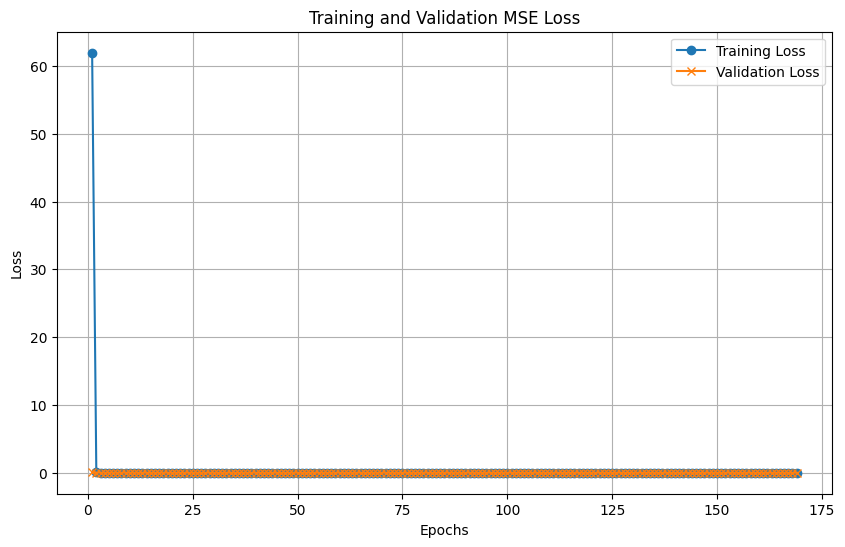

Testing: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s, loss=0.00204]

Test Loss: 0.004254
Training completed!
Best validation loss: 0.004076
Final test loss: 0.004254


In [3]:
# Plot training history
plot_training_history(history)

# Evaluate on test set
test_loss = evaluate_model(device, model, test_loader, criterion)

print("Training completed!")
print(f"Best validation loss: {min(history['val_loss']):.6f}")
print(f"Final test loss: {test_loss:.6f}")